In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from tqdm import tqdm
import math
from sklearn.metrics import precision_score, recall_score, f1_score
import time
import csv

In [2]:
class Conv2d_cd(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1,
                 padding=1, dilation=1, groups=1, bias=False, theta=0.7):

        super(Conv2d_cd, self).__init__() 
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.theta = theta

    def forward(self, x):
        out_normal = self.conv(x)

        if math.fabs(self.theta - 0.0) < 1e-8:
            return out_normal 
        else:
            #pdb.set_trace()
            [C_out,C_in, kernel_size,kernel_size] = self.conv.weight.shape
            kernel_diff = self.conv.weight.sum(2).sum(2)
            kernel_diff = kernel_diff[:, :, None, None]
            out_diff = F.conv2d(input=x, weight=kernel_diff, bias=self.conv.bias, stride=self.conv.stride, padding=0, groups=self.conv.groups)

            return out_normal - self.theta * out_diff

In [ ]:
class CDCN(nn.Module):

    def __init__(self, basic_conv=Conv2d_cd, theta=0.7):   
        super(CDCN, self).__init__()
          
        self.conv1 = nn.Sequential(
            basic_conv(3, 64, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(64),
            nn.ReLU(),    
        )
        
        self.Block1 = nn.Sequential(
            basic_conv(64, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),   
            basic_conv(128, 196, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(196),
            nn.ReLU(),  
            basic_conv(196, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),   
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
        )
        
        self.Block2 = nn.Sequential(
            basic_conv(128, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),   
            basic_conv(128, 196, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(196),
            nn.ReLU(),  
            basic_conv(196, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.Block3 = nn.Sequential(
            basic_conv(128, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),   
            basic_conv(128, 196, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(196),
            nn.ReLU(),  
            basic_conv(196, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),   
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.lastconv1 = nn.Sequential(
            basic_conv(128*3, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),    
        )
        
        self.lastconv2 = nn.Sequential(
            basic_conv(128, 64, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(64),
            nn.ReLU(),    
        )
        
        self.lastconv3 = nn.Sequential(
            basic_conv(64, 1, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.ReLU(),    
        )
        
        self.downsample32x32 = nn.Upsample(size=(32, 32), mode='bilinear')

 
    def forward(self, x):	    	# x [3, 256, 256]
        
        x_input = x
        x = self.conv1(x)		   
        
        x_Block1 = self.Block1(x)	    	    	# x [128, 128, 128]
        x_Block1_32x32 = self.downsample32x32(x_Block1)   # x [128, 32, 32]  
        
        x_Block2 = self.Block2(x_Block1)	    # x [128, 64, 64]	  
        x_Block2_32x32 = self.downsample32x32(x_Block2)   # x [128, 32, 32]  
        
        x_Block3 = self.Block3(x_Block2)	    # x [128, 32, 32]  	
        x_Block3_32x32 = self.downsample32x32(x_Block3)   # x [128, 32, 32]  
        
        x_concat = torch.cat((x_Block1_32x32,x_Block2_32x32,x_Block3_32x32), dim=1)    # x [128*3, 32, 32]  
        
        # pdb.set_trace()
        
        x = self.lastconv1(x_concat)    # x [128, 32, 32] 
        x = self.lastconv2(x)    # x [64, 32, 32] 
        x = self.lastconv3(x)    # x [1, 32, 32] 
        
        map_x = x.squeeze(1)
        
        return map_x, x_concat, x_Block1, x_Block2, x_Block3, x_input

In [6]:
class FaceSpoofDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, "photo", self.data.iloc[idx, 0])
        label = int(self.data.iloc[idx, 1])
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"⚠️ Lỗi đọc ảnh {img_path}: {e}")
            return torch.zeros(3, 256, 256), 0  # ảnh rỗng fallback

        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
class CDCN_Binary(nn.Module):
    def __init__(self, theta=0.7):
        super(CDCN_Binary, self).__init__()
        self.feature_extractor = CDCN(basic_conv=Conv2d_cd, theta=theta)
        self.fc = nn.Linear(32*32, 2)  # flatten depth map -> 2 classes

    def forward(self, x):
        map_x, *_ = self.feature_extractor(x)
        out = map_x.view(map_x.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
# CONFIG
csv_path = "dataset_processed/photo/list_filtered.csv"
root_dir = "dataset_processed"
batch_size = 8
lr = 1e-4
epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# DATA
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = FaceSpoofDataset(csv_file=csv_path, root_dir=root_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(train_size, val_size)

3480 870


In [ ]:
# MODEL
model = CDCN_Binary(theta=0.7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
log_path = "baseline_training_log.csv"
best_model_path = "checkpoint/best_cdcn_baseline.pth"
os.makedirs("checkpoint", exist_ok=True)

# Early stopping config
patience = 5
best_val_acc = 0.0
epochs_no_improve = 0

# Ghi header CSV
with open(log_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "lr", "train_loss", "val_loss",
                     "train_acc", "val_acc", "precision", "recall", "f1_score", "epoch_time_sec"])
    
# TRAINING
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    total_loss, correct, total = 0, 0, 0
    all_labels, all_preds = [], []

    # TRAIN LOOP
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    train_acc = correct / total * 100
    train_loss = total_loss / len(train_loader)
    train_precision = precision_score(all_labels, all_preds, zero_division=0)
    train_recall = recall_score(all_labels, all_preds, zero_division=0)
    train_f1 = f1_score(all_labels, all_preds, zero_division=0)

    # VALIDATION LOOP
    model.eval()
    correct, total = 0, 0
    val_loss, all_labels, all_preds = 0, [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_acc = correct / total * 100
    val_loss /= len(val_loader)
    val_precision = precision_score(all_labels, all_preds, zero_division=0)
    val_recall = recall_score(all_labels, all_preds, zero_division=0)
    val_f1 = f1_score(all_labels, all_preds, zero_division=0)
    epoch_time = time.time() - start_time

    # Ghi log ra CSV
    with open(log_path, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            epoch + 1, optimizer.param_groups[0]["lr"],
            train_loss, val_loss, train_acc, val_acc,
            val_precision, val_recall, val_f1, epoch_time
        ])

    # Hiển thị tiến trình
    print(f"[Epoch {epoch+1}] "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | "
          f"F1: {val_f1:.3f} | Time: {epoch_time:.1f}s")

    # Lưu checkpoint tốt nhất
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"💾 Saved new best model (val_acc={val_acc:.2f}%) at epoch {epoch+1}")
    else:
        epochs_no_improve += 1
        print(f"⚠️ No improvement ({epochs_no_improve}/{patience})")

    # Kiểm tra dừng sớm
    if epochs_no_improve >= patience:
        print(f"⏹️ Early stopping triggered after {epoch+1} epochs (best val_acc={best_val_acc:.2f}%)")
        break

print("✅ Training finished.")
print(f"📂 Best checkpoint saved at: {best_model_path}")

Epoch 1/15: 100%|██████████| 435/435 [07:18<00:00,  1.01s/it]


[Epoch 1] Train Acc: 93.22% | Val Acc: 96.67% | F1: 0.980 | Time: 467.3s
💾 Saved new best model (val_acc=96.67%) at epoch 1


Epoch 2/15: 100%|██████████| 435/435 [07:36<00:00,  1.05s/it]


[Epoch 2] Train Acc: 97.13% | Val Acc: 96.90% | F1: 0.982 | Time: 485.7s
💾 Saved new best model (val_acc=96.90%) at epoch 2


Epoch 3/15: 100%|██████████| 435/435 [07:36<00:00,  1.05s/it]


[Epoch 3] Train Acc: 98.13% | Val Acc: 97.59% | F1: 0.986 | Time: 485.5s
💾 Saved new best model (val_acc=97.59%) at epoch 3


Epoch 4/15: 100%|██████████| 435/435 [07:36<00:00,  1.05s/it]


[Epoch 4] Train Acc: 98.48% | Val Acc: 97.47% | F1: 0.985 | Time: 485.8s
⚠️ No improvement (1/5)


Epoch 5/15: 100%|██████████| 435/435 [07:34<00:00,  1.04s/it]


[Epoch 5] Train Acc: 99.28% | Val Acc: 97.36% | F1: 0.984 | Time: 483.7s
⚠️ No improvement (2/5)


Epoch 6/15: 100%|██████████| 435/435 [07:35<00:00,  1.05s/it]


[Epoch 6] Train Acc: 99.11% | Val Acc: 97.59% | F1: 0.986 | Time: 484.8s
⚠️ No improvement (3/5)


Epoch 7/15: 100%|██████████| 435/435 [07:35<00:00,  1.05s/it]


[Epoch 7] Train Acc: 99.45% | Val Acc: 96.78% | F1: 0.981 | Time: 484.9s
⚠️ No improvement (4/5)


Epoch 8/15: 100%|██████████| 435/435 [07:34<00:00,  1.05s/it]


[Epoch 8] Train Acc: 99.43% | Val Acc: 98.05% | F1: 0.988 | Time: 483.6s
💾 Saved new best model (val_acc=98.05%) at epoch 8


Epoch 9/15: 100%|██████████| 435/435 [07:33<00:00,  1.04s/it]


[Epoch 9] Train Acc: 98.94% | Val Acc: 97.59% | F1: 0.986 | Time: 482.5s
⚠️ No improvement (1/5)


Epoch 10/15: 100%|██████████| 435/435 [07:32<00:00,  1.04s/it]


[Epoch 10] Train Acc: 99.91% | Val Acc: 97.36% | F1: 0.984 | Time: 481.5s
⚠️ No improvement (2/5)


Epoch 11/15: 100%|██████████| 435/435 [07:33<00:00,  1.04s/it]


[Epoch 11] Train Acc: 100.00% | Val Acc: 97.70% | F1: 0.986 | Time: 482.3s
⚠️ No improvement (3/5)


Epoch 12/15: 100%|██████████| 435/435 [07:31<00:00,  1.04s/it]


[Epoch 12] Train Acc: 100.00% | Val Acc: 97.82% | F1: 0.987 | Time: 480.5s
⚠️ No improvement (4/5)


Epoch 13/15: 100%|██████████| 435/435 [07:32<00:00,  1.04s/it]


[Epoch 13] Train Acc: 100.00% | Val Acc: 97.70% | F1: 0.986 | Time: 481.3s
⚠️ No improvement (5/5)
⏹️ Early stopping triggered after 13 epochs (best val_acc=98.05%)
✅ Training finished.
📂 Best checkpoint saved at: checkpoint/best_cdcn_baseline.pth


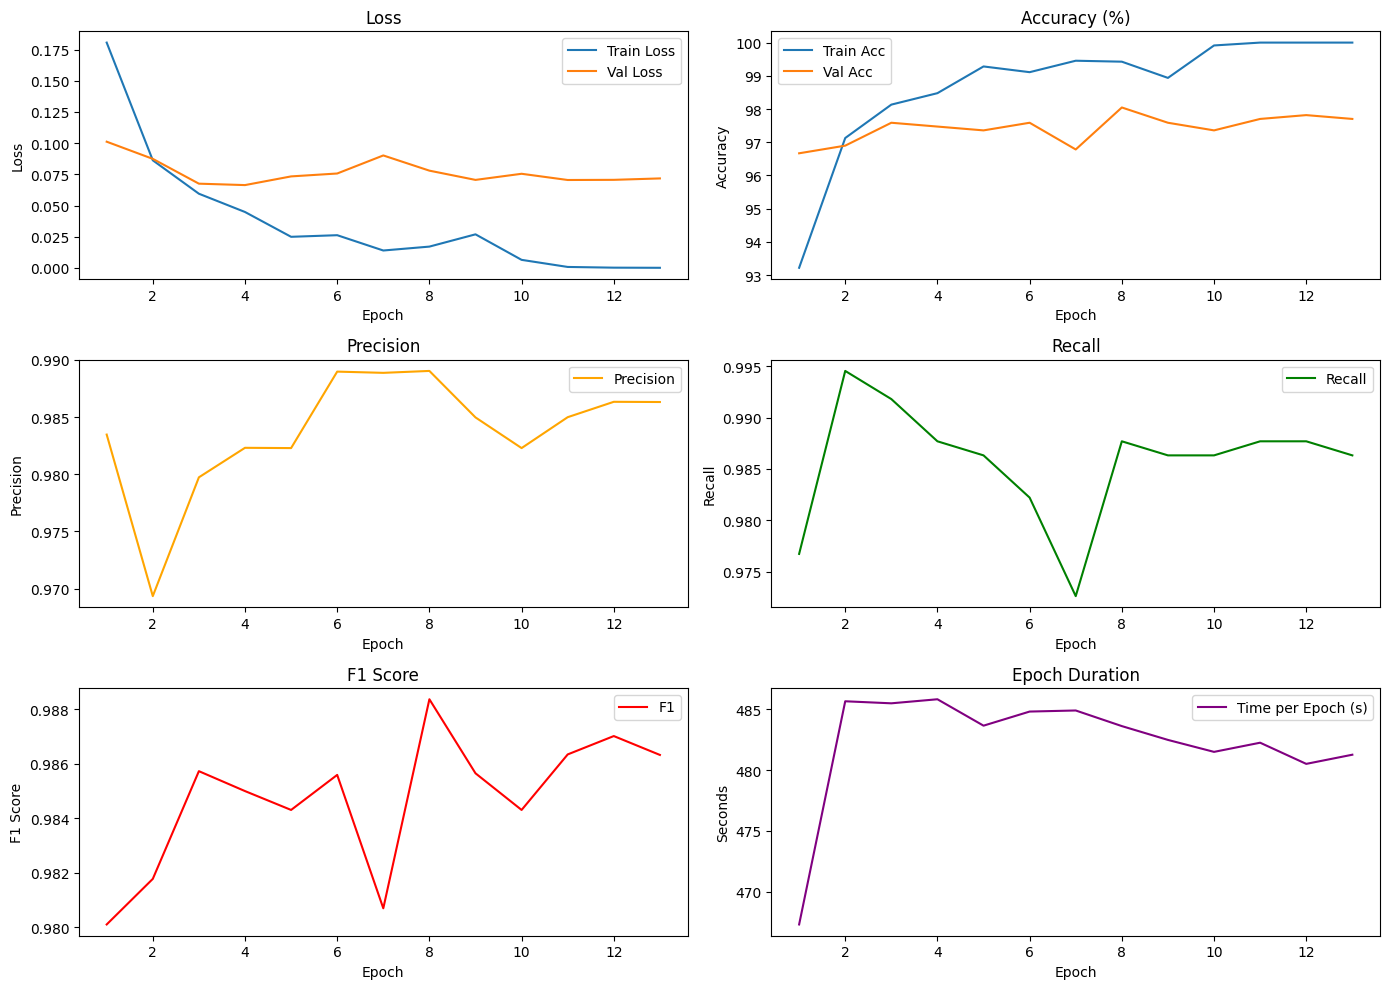

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("baseline_training_log.csv")

plt.figure(figsize=(14, 10))

# Loss
plt.subplot(3, 2, 1)
plt.plot(df["epoch"], df["train_loss"], label="Train Loss")
plt.plot(df["epoch"], df["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

# Accuracy
plt.subplot(3, 2, 2)
plt.plot(df["epoch"], df["train_acc"], label="Train Acc")
plt.plot(df["epoch"], df["val_acc"], label="Val Acc")
plt.title("Accuracy (%)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

# Precision
plt.subplot(3, 2, 3)
plt.plot(df["epoch"], df["precision"], label="Precision", color="orange")
plt.title("Precision")
plt.xlabel("Epoch"); plt.ylabel("Precision"); plt.legend()

# Recall
plt.subplot(3, 2, 4)
plt.plot(df["epoch"], df["recall"], label="Recall", color="green")
plt.title("Recall")
plt.xlabel("Epoch"); plt.ylabel("Recall"); plt.legend()

# F1 Score
plt.subplot(3, 2, 5)
plt.plot(df["epoch"], df["f1_score"], label="F1", color="red")
plt.title("F1 Score")
plt.xlabel("Epoch"); plt.ylabel("F1 Score"); plt.legend()

# Epoch Time
plt.subplot(3, 2, 6)
plt.plot(df["epoch"], df["epoch_time_sec"], label="Time per Epoch (s)", color="purple")
plt.title("Epoch Duration")
plt.xlabel("Epoch"); plt.ylabel("Seconds"); plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Load model
model = CDCN_Binary(theta=0.7).to(device)
model.load_state_dict(torch.load("checkpoint/best_cdcn_baseline.pth", map_location=device))
model.eval()

# Đánh giá trên tập validation
all_labels, all_preds = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("Classification Report:\n", classification_report(all_labels, all_preds, digits=4))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))


C:\Users\Admin\AppData\Local\Temp\ipykernel_2720\1765983102.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint/best_cdcn_baseli

Classification Report:
               precision    recall  f1-score   support

           0     0.9357    0.9424    0.9391       139
           1     0.9890    0.9877    0.9884       731

    accuracy                         0.9805       870
   macro avg     0.9624    0.9651    0.9637       870
weighted avg     0.9805    0.9805    0.9805       870

Confusion Matrix:
 [[131   8]
 [  9 722]]


C:\Users\Admin\AppData\Local\Temp\ipykernel_2720\1641645801.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locatio

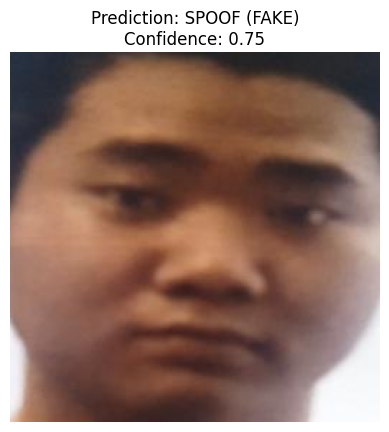

Model Prediction: SPOOF (FAKE)
Confidence: 0.7495


In [40]:
# Cấu hình
image_path = "dataset_processed/photo2/not_live/3fb02690-b136-11ed-95c0-b42e9920aa06_face_image_live_3f92f26e-b136-11ed-80d1-b42e9920aa05.jpg"
checkpoint_path = "checkpoint/best_cdcn_baseline.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = CDCN_Binary(theta=0.7).to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

# Tiền xử lý ảnh
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Đọc ảnh
img = Image.open(image_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)

# Dự đoán
with torch.no_grad():
    output = model(input_tensor)
    pred = torch.argmax(output, dim=1).item()
    confidence = torch.softmax(output, dim=1)[0][pred].item()

# Kết quả
label_map = {0: "SPOOF (FAKE)", 1: "LIVE (REAL)"}
pred_label = label_map[pred]

plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {pred_label}\nConfidence: {confidence:.2f}")
plt.show()

print(f"Model Prediction: {pred_label}")
print(f"Confidence: {confidence:.4f}")